# Yellow Taxi Analytics (auto-detect)

This notebook auto-detects schema and computes aggregated analytics.

In [1]:
from pathlib import Path

# compute repo root dynamically
REPO_ROOT = Path.cwd().resolve().parent

# IMPORTANT: must point to 'data/raw', not 'data'
DATA_BASE = str(REPO_ROOT / "data" / "raw")

DATA_TYPE = "yellow"    # will be different in each notebook
YEARS = [2025]
OUTPUT_BASE = str(REPO_ROOT / "data" / "local_output" / "analytics")

print("Repo root:", REPO_ROOT)
print("DATA_BASE:", DATA_BASE)
print("Looking in:", Path(DATA_BASE) / DATA_TYPE)


Repo root: C:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl
DATA_BASE: C:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl\data\raw
Looking in: C:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl\data\raw\yellow


In [2]:
import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
files = None
print('Preparing to detect files...')

Preparing to detect files...


In [4]:
from pathlib import Path
p = Path(DATA_BASE) / DATA_TYPE
files = []
for y in YEARS:
    q = p / str(y)
    if q.exists():
        files += sorted([str(f) for f in q.glob('*.parquet')])
files += sorted([str(f) for f in (p.rglob('*.parquet')) if any(str(y) in f.name for y in YEARS)])
files = list(dict.fromkeys(files))
print('Found', len(files), 'files for', DATA_TYPE, 'at', p.resolve())
files[:10]


Found 9 files for yellow at C:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl\data\raw\yellow


['C:\\All Data\\Studies\\Msc Rutgers\\Semester 3\\Cloud computing\\Project\\nyc-taxi-etl\\data\\raw\\yellow\\2025\\yellow_tripdata_2025-01.parquet',
 'C:\\All Data\\Studies\\Msc Rutgers\\Semester 3\\Cloud computing\\Project\\nyc-taxi-etl\\data\\raw\\yellow\\2025\\yellow_tripdata_2025-02.parquet',
 'C:\\All Data\\Studies\\Msc Rutgers\\Semester 3\\Cloud computing\\Project\\nyc-taxi-etl\\data\\raw\\yellow\\2025\\yellow_tripdata_2025-03.parquet',
 'C:\\All Data\\Studies\\Msc Rutgers\\Semester 3\\Cloud computing\\Project\\nyc-taxi-etl\\data\\raw\\yellow\\2025\\yellow_tripdata_2025-04.parquet',
 'C:\\All Data\\Studies\\Msc Rutgers\\Semester 3\\Cloud computing\\Project\\nyc-taxi-etl\\data\\raw\\yellow\\2025\\yellow_tripdata_2025-05.parquet',
 'C:\\All Data\\Studies\\Msc Rutgers\\Semester 3\\Cloud computing\\Project\\nyc-taxi-etl\\data\\raw\\yellow\\2025\\yellow_tripdata_2025-06.parquet',
 'C:\\All Data\\Studies\\Msc Rutgers\\Semester 3\\Cloud computing\\Project\\nyc-taxi-etl\\data\\raw\\yello

In [5]:
if not files:
    print('No files found; edit DATA_BASE/DATA_TYPE/YEARS at top to point to your parquet files.')
    import pandas as pd
    df_hour = pd.DataFrame(columns=['pickup_hour','avg_fare_per_mile','trip_count'])
    df_dow = pd.DataFrame(columns=['pickup_dow','trip_count'])
    df_pu = pd.DataFrame(columns=['PULocationID','trip_count'])
    df_do = pd.DataFrame(columns=['DOLocationID','trip_count'])
    df_month = pd.DataFrame()
else:
    pass


In [6]:
# --- Robust schema detection + aggregator ---

import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path

# Helper: list files
def list_files(base, dtype, years):
    p = Path(base) / dtype
    files = []
    for y in years:
        q = p / str(y)
        if q.exists():
            files += sorted([str(f) for f in q.glob("*.parquet")])

    # fallback catch-all: match years in filename
    files += sorted([
        str(f) for f in p.rglob("*.parquet")
        if any(str(y) in f.name for y in years)
    ])

    # de-duplicate
    files = list(dict.fromkeys(files))
    return files

# Auto-detect schema
def detect_schema(file_path):
    schema = pq.read_schema(file_path).names
    
    pick_candidates = [
        "tpep_pickup_datetime","lpep_pickup_datetime",
        "pickup_datetime","request_datetime"
    ]
    drop_candidates = [
        "tpep_dropoff_datetime","lpep_dropoff_datetime",
        "dropoff_datetime","dropOff_datetime"
    ]
    distance_candidates = ["trip_distance","trip_miles"]
    fare_candidates = ["fare_amount","total_amount","base_passenger_fare"]
    pu_candidates = ["PULocationID","PUlocationID"]
    do_candidates = ["DOLocationID","DOlocationID"]

    def find_any(cands):
        for c in cands:
            for col in schema:
                if c.lower() == col.lower():
                    return col
        for c in cands:
            for col in schema:
                if c.lower() in col.lower():
                    return col
        return None

    return {
        "pickup":   find_any(pick_candidates),
        "dropoff":  find_any(drop_candidates),
        "distance": find_any(distance_candidates),
        "fare":     find_any(fare_candidates),
        "pu":       find_any(pu_candidates),
        "do":       find_any(do_candidates)
    }


# Read parquet safely
def read_light(path, cols=None):
    try:
        tbl = pq.read_table(path, columns=cols) if cols else pq.read_table(path)
        return tbl.to_pandas()
    except Exception as e:
        print(f"Read failed for {path} → {e}")
        return pd.DataFrame()


# Master aggregation function
def compute_aggregates(files, detected):
    import pandas as pd  # <<< IMPORTANT FIX

    from collections import defaultdict
    agg = {
        "fare_hour": defaultdict(lambda: {"sum":0.0, "count":0}),
        "dow": defaultdict(int),
        "pu": defaultdict(int),
        "do": defaultdict(int),
        "month": defaultdict(lambda: {"sum":0.0, "count":0})
    }

    for i, f in enumerate(files, 1):
        print(f"[{i}/{len(files)}] processing {f}")
        
        schema = pq.read_schema(f).names
        
        cols = [c for c in [
            detected["pickup"], detected["dropoff"],
            detected["distance"], detected["fare"],
            detected["pu"], detected["do"]
        ] if c and c in schema]

        df = read_light(f, cols)
        if df.empty:
            continue

        # Normalize timestamp fields
        if detected["pickup"] in df.columns:
            df[detected["pickup"]] = pd.to_datetime(df[detected["pickup"]], errors="coerce")
            df["pickup_hour"] = df[detected["pickup"]].dt.hour
            df["pickup_dow"] = df[detected["pickup"]].dt.day_name().str[:3]
            df["pickup_month"] = df[detected["pickup"]].dt.to_period("M").astype(str)

        # Distance
        if detected["distance"] in df.columns:
            df[detected["distance"]] = pd.to_numeric(df[detected["distance"]], errors="coerce")

        # Fare
        if detected["fare"] in df.columns:
            df["fare_amount_calc"] = pd.to_numeric(df[detected["fare"]], errors="coerce")

        # Fare per mile
        if (detected["distance"] in df.columns) and ("fare_amount_calc" in df.columns):
            df = df[(df[detected["distance"]] > 0) & (~df["fare_amount_calc"].isna())]
            df["fare_per_mile"] = df["fare_amount_calc"] / df[detected["distance"]]
        else:
            df["fare_per_mile"] = None

        # PU/DO normalization
        if detected["pu"] in df.columns:
            df["PULocationID_std"] = pd.to_numeric(df[detected["pu"]], errors="coerce").astype("Int64")
        if detected["do"] in df.columns:
            df["DOLocationID_std"] = pd.to_numeric(df[detected["do"]], errors="coerce").astype("Int64")

        # Aggregations
        # Hourly fare
        if "pickup_hour" in df.columns:
            g = df.groupby("pickup_hour")["fare_per_mile"].agg(["sum", "count"])
            for h, r in g.iterrows():
                agg["fare_hour"][h]["sum"] += r["sum"] if pd.notna(r["sum"]) else 0.0
                agg["fare_hour"][h]["count"] += r["count"]

        # Day of week
        if "pickup_dow" in df.columns:
            g = df.groupby("pickup_dow").size()
            for dow, cnt in g.items():
                agg["dow"][dow] += cnt

        # PU
        if "PULocationID_std" in df.columns:
            g = df.groupby("PULocationID_std").size()
            for k, cnt in g.items():
                if pd.notna(k):
                    agg["pu"][int(k)] += cnt

        # DO
        if "DOLocationID_std" in df.columns:
            g = df.groupby("DOLocationID_std").size()
            for k, cnt in g.items():
                if pd.notna(k):
                    agg["do"][int(k)] += cnt

        # Monthly
        if "pickup_month" in df.columns:
            g = df.groupby("pickup_month")["fare_per_mile"].agg(["sum", "count"])
            for m, r in g.iterrows():
                agg["month"][m]["sum"] += r["sum"] if pd.notna(r["sum"]) else 0.0
                agg["month"][m]["count"] += r["count"]

    # Convert dicts → dataframes
    df_hour = pd.DataFrame([
        {"pickup_hour": h,
         "avg_fare_per_mile": (vals["sum"]/vals["count"] if vals["count"]>0 else None),
         "trip_count": vals["count"]}
        for h, vals in sorted(agg["fare_hour"].items())
    ])

    df_dow = pd.DataFrame([
        {"pickup_dow": dow, "trip_count": cnt}
        for dow, cnt in agg["dow"].items()
    ])

    df_pu = pd.DataFrame([
        {"PULocationID": k, "trip_count": cnt}
        for k, cnt in sorted(agg["pu"].items(), key=lambda x:-x[1])
    ])

    df_do = pd.DataFrame([
        {"DOLocationID": k, "trip_count": cnt}
        for k, cnt in sorted(agg["do"].items(), key=lambda x:-x[1])
    ])

    df_month = pd.DataFrame([
        {"month": m,
         "avg_fare_per_mile": (vals["sum"]/vals["count"] if vals["count"]>0 else None),
         "trip_count": vals["count"]}
        for m, vals in sorted(agg["month"].items())
    ])

    return df_hour, df_dow, df_pu, df_do, df_month


In [7]:
if files:
    detected = detect_schema(files[0])
    print('Detected schema sample:', detected)
    df_hour, df_dow, df_pu, df_do, df_month = compute_aggregates(files, detected)
else:
    print('No files to process')

Detected schema sample: {'pickup': 'tpep_pickup_datetime', 'dropoff': 'tpep_dropoff_datetime', 'distance': 'trip_distance', 'fare': 'fare_amount', 'pu': 'PULocationID', 'do': 'DOLocationID'}
[1/9] processing C:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl\data\raw\yellow\2025\yellow_tripdata_2025-01.parquet
[2/9] processing C:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl\data\raw\yellow\2025\yellow_tripdata_2025-02.parquet
[3/9] processing C:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl\data\raw\yellow\2025\yellow_tripdata_2025-03.parquet
[4/9] processing C:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl\data\raw\yellow\2025\yellow_tripdata_2025-04.parquet
[5/9] processing C:\All Data\Studies\Msc Rutgers\Semester 3\Cloud computing\Project\nyc-taxi-etl\data\raw\yellow\2025\yellow_tripdata_2025-05.parquet
[6/9] processing C:\All Data\Studies\Msc Rutgers\Semester 3

Computing trip counts by hour from raw files (fast, per-file scanning)...
Done. Sample:


,pickup_hour,trip_count
0,0,1136646
1,1,749003
2,2,494763
3,3,337196
4,4,261716
5,5,279049
6,6,549646
7,7,1005615
8,8,1373335
9,9,1461706


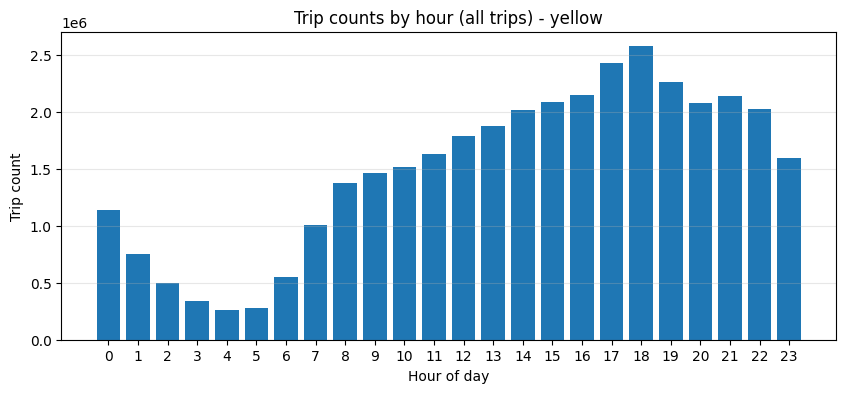

In [8]:
# Compute trip counts by hour even when fare/distance are missing
import pyarrow.parquet as pq
import pandas as pd
from collections import Counter
from pathlib import Path

print("Computing trip counts by hour from raw files (fast, per-file scanning)...")
hour_counter = Counter()
for i,f in enumerate(files, 1):
    try:
        schema = pq.read_schema(f).names
        # find pickup column name in schema
        pickup_col = next((c for c in schema if 'pickup' in c.lower()), None)
        if not pickup_col:
            continue
        tbl = pq.read_table(f, columns=[pickup_col])
        df_tmp = tbl.to_pandas()
        df_tmp[pickup_col] = pd.to_datetime(df_tmp[pickup_col], errors='coerce')
        hrs = df_tmp[pickup_col].dt.hour.dropna().astype(int)
        hour_counter.update(hrs.tolist())
    except Exception as e:
        print("skip", f, e)

# build dataframe
df_hour_counts = pd.DataFrame([
    {"pickup_hour": h, "trip_count": hour_counter.get(h, 0)}
    for h in range(24)
])
print("Done. Sample:")
display(df_hour_counts.head(24))

# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.bar(df_hour_counts['pickup_hour'], df_hour_counts['trip_count'])
plt.title(f"Trip counts by hour (all trips) - {DATA_TYPE}")
plt.xlabel("Hour of day")
plt.ylabel("Trip count")
plt.xticks(range(0,24))
plt.grid(axis='y', alpha=0.3)
plt.show()


Monthly trip counts:


,month,trip_count
0,2007-12,1
1,2009-01,4
2,2024-12,21
3,2025-01,3475234
4,2025-02,3577542
5,2025-03,4145229
6,2025-04,3970568
7,2025-05,4591844
8,2025-06,4322949
9,2025-07,3898971


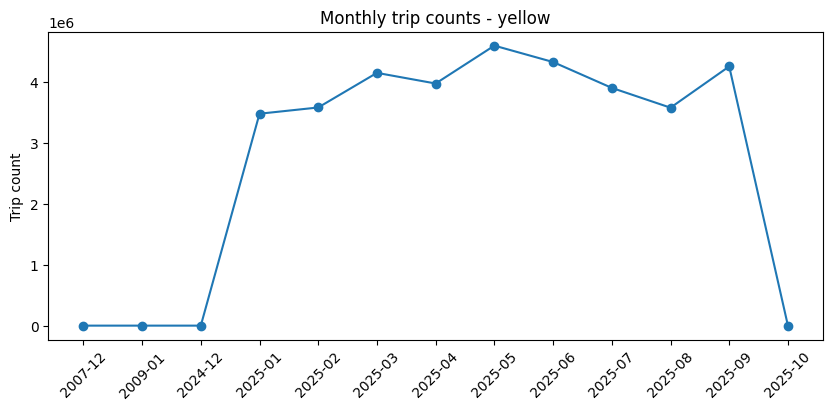

In [9]:
# Compute monthly trip counts (YYYY-MM) from raw files
import pyarrow.parquet as pq
import pandas as pd
from collections import Counter
from pathlib import Path

month_counter = Counter()
for i,f in enumerate(files, 1):
    try:
        schema = pq.read_schema(f).names
        pickup_col = next((c for c in schema if 'pickup' in c.lower()), None)
        if not pickup_col:
            continue
        tbl = pq.read_table(f, columns=[pickup_col])
        df_tmp = tbl.to_pandas()
        df_tmp[pickup_col] = pd.to_datetime(df_tmp[pickup_col], errors='coerce')
        months = df_tmp[pickup_col].dt.to_period("M").dropna().astype(str)
        month_counter.update(months.tolist())
    except Exception as e:
        print("skip", f, e)

df_month_counts = pd.DataFrame(sorted([
    {"month": m, "trip_count": c}
    for m, c in month_counter.items()
], key=lambda x: x["month"]))

print("Monthly trip counts:")
display(df_month_counts)
# plot
import matplotlib.pyplot as plt
if not df_month_counts.empty:
    plt.figure(figsize=(10,4))
    plt.plot(df_month_counts['month'], df_month_counts['trip_count'], marker='o')
    plt.title(f"Monthly trip counts - {DATA_TYPE}")
    plt.xticks(rotation=45)
    plt.ylabel("Trip count")
    plt.show()
else:
    print("No monthly counts found.")



== Trips by day of week ==


,pickup_dow,trip_count
0,Fri,5098170
1,Mon,4203359
2,Sat,5500320
3,Sun,4693422
4,Thu,5335035
5,Tue,4821771
6,Wed,5140093


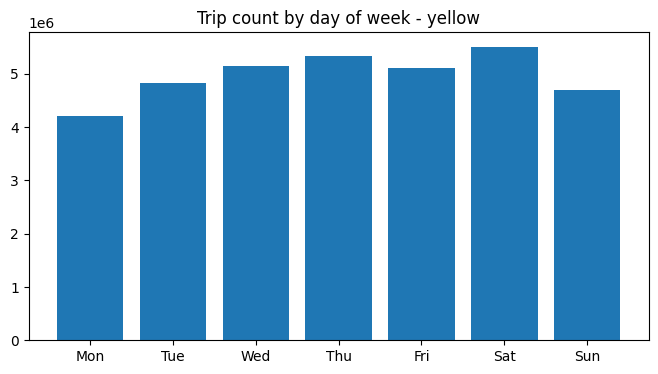


== Top 10 pickup zones ==


,PULocationID,trip_count
0,161,1522173
1,237,1506054
2,132,1505180
3,236,1323343
4,186,1122950
5,230,1113926
6,162,1090540
7,142,978643
8,170,937521
9,138,936496


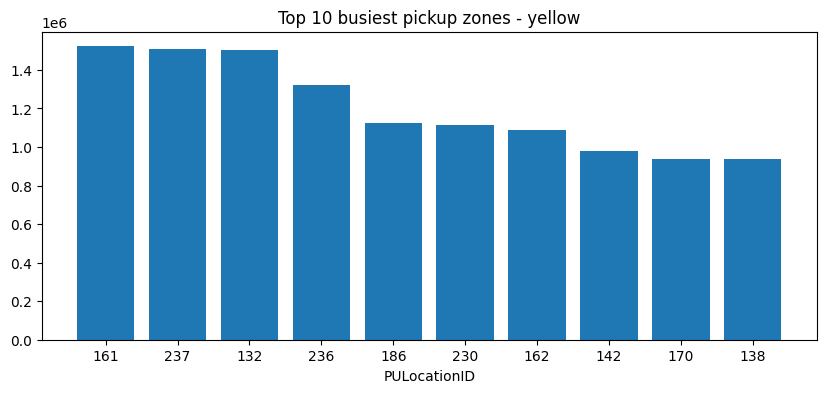


== Top 10 dropoff zones ==


,DOLocationID,trip_count
0,236,1383840
1,237,1363368
2,161,1243454
3,230,1052023
4,170,978926
5,162,928492
6,68,895910
7,239,870469
8,142,869481
9,141,830870


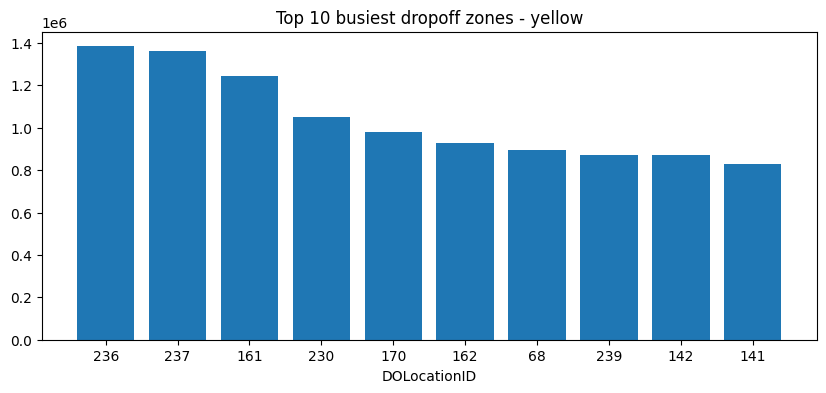


== Trip duration distribution (minutes) ==


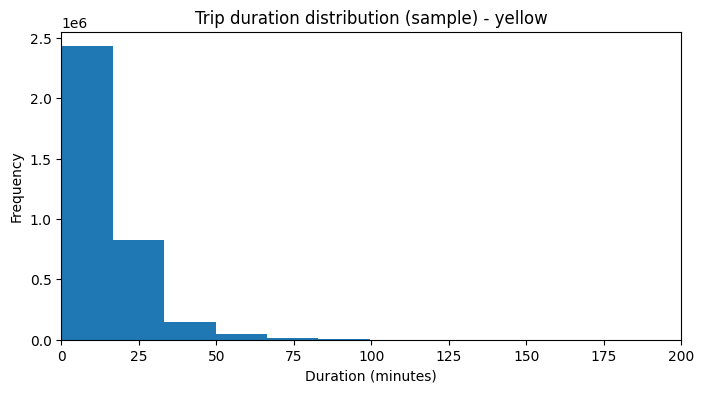

In [10]:
# Robust plotting & finalization (handles missing fare/distance)
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# ----- df_hour may contain avg_fare_per_mile and trip_count, but if avg is None we still want trip counts by hour -----

# ----- Trips by day of week -----
print("\n== Trips by day of week ==")
if 'df_dow' in globals() and not df_dow.empty and df_dow['trip_count'].sum() > 0:
    display(df_dow)
    order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    try:
        df_dow2 = df_dow.set_index('pickup_dow').reindex(order).fillna(0).reset_index()
    except Exception:
        df_dow2 = df_dow
    plt.figure(figsize=(8,4))
    plt.bar(df_dow2['pickup_dow'], df_dow2['trip_count'])
    plt.title(f"Trip count by day of week - {DATA_TYPE}")
    plt.show()
else:
    print("No trip-by-day data available.")

# ----- Busiest pickup/dropoff zones (top 10) -----
print("\n== Top 10 pickup zones ==")
if 'df_pu' in globals() and not df_pu.empty:
    display(df_pu.head(10))
    top10 = df_pu.head(10)
    plt.figure(figsize=(10,4))
    plt.bar(top10['PULocationID'].astype(str), top10['trip_count'])
    plt.title(f"Top 10 busiest pickup zones - {DATA_TYPE}")
    plt.xlabel("PULocationID")
    plt.show()
else:
    print("No pickup zone data available.")

print("\n== Top 10 dropoff zones ==")
if 'df_do' in globals() and not df_do.empty:
    display(df_do.head(10))
    top10d = df_do.head(10)
    plt.figure(figsize=(10,4))
    plt.bar(top10d['DOLocationID'].astype(str), top10d['trip_count'])
    plt.title(f"Top 10 busiest dropoff zones - {DATA_TYPE}")
    plt.xlabel("DOLocationID")
    plt.show()
else:
    print("No dropoff zone data available.")

# ----- Trip duration distribution (if timestamps exist) -----
print("\n== Trip duration distribution (minutes) ==")
# Try to compute distribution using detected pickup/drop columns
duration_drawn = False
candidate_pickup = None
candidate_dropoff = None
# Attempt to find pickup & drop column names from files or previously loaded df
for col in ['tpep_pickup_datetime','lpep_pickup_datetime','pickup_datetime','request_datetime']:
    if col in globals().get('df_hour', pd.DataFrame()).columns:
        candidate_pickup = col
        break
# fallback: try looking at the first file to find a pickup/drop column
if not candidate_pickup:
    try:
        # find first file from earlier 'files' var
        import pyarrow.parquet as pq, pandas as pd
        if 'files' in globals() and files:
            sc = pq.read_schema(files[0]).names
            for col in sc:
                if 'pickup' in col.lower():
                    candidate_pickup = col
                if 'drop' in col.lower():
                    candidate_dropoff = col
    except Exception:
        pass

# If we have pickup/drop within earlier readframes, compute durations
# We'll try to read a small sample file to compute durations if needed
if 'files' in globals() and files:
    sample = files[0]
    try:
        import pyarrow.parquet as pq
        cols = []
        if candidate_pickup: cols.append(candidate_pickup)
        if candidate_dropoff: cols.append(candidate_dropoff)
        # also fallback to read any timestamp-like columns
        tbl = pq.read_table(sample)
        df_sample = tbl.to_pandas()
        # heuristics: find pickup/drop column names in sample
        if not candidate_pickup:
            for c in df_sample.columns:
                if 'pickup' in c.lower():
                    candidate_pickup = c
        if not candidate_dropoff:
            for c in df_sample.columns:
                if 'drop' in c.lower():
                    candidate_dropoff = c
        if candidate_pickup and candidate_dropoff and candidate_pickup in df_sample.columns and candidate_dropoff in df_sample.columns:
            df_sample[candidate_pickup] = pd.to_datetime(df_sample[candidate_pickup], errors='coerce')
            df_sample[candidate_dropoff] = pd.to_datetime(df_sample[candidate_dropoff], errors='coerce')
            # compute minutes
            df_sample['trip_duration_min'] = (df_sample[candidate_dropoff] - df_sample[candidate_pickup]).dt.total_seconds()/60.0
            # drop nulls and extremes
            dur = df_sample['trip_duration_min'].dropna()
            dur = dur[(dur > 0) & (dur < 1000)]  # filter nonsense
            if len(dur) > 0:
                plt.figure(figsize=(8,4))
                plt.hist(dur, bins=60)
                plt.title(f"Trip duration distribution (sample) - {DATA_TYPE}")
                plt.xlabel("Duration (minutes)")
                plt.ylabel("Frequency")
                plt.xlim(0, 200)
                plt.show()
                duration_drawn = True
    except Exception as e:
        print("Could not compute trip durations:", e)

if not duration_drawn:
    print("Trip duration distribution unavailable (missing pickup/dropoff timestamps in accessible schema).")



Run all cells in the notebook and then *Save* the notebook file.  
Saving after execution will embed the generated plots (images) inside the `.ipynb` file so next time you open the notebook you will see the plots without re-running.

If you want zone names (e.g. map PULocationID -> Borough/Zone name) we can add the TLC lookup CSV into the notebook; say 'add zone lookup' and I will patch them.
